# Stress level voorspellen

### Imports

In [ ]:
import kagglehub
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV


### Data importeren

In [2]:


# Download latest version
path = kagglehub.dataset_download("amar5693/screen-time-sleep-and-stress-analysis-dataset")

print("Path to dataset files:", path)
print(os.listdir(path))


Path to dataset files: C:\Users\Nima\.cache\kagglehub\datasets\amar5693\screen-time-sleep-and-stress-analysis-dataset\versions\1
['Smartphone_Usage_Productivity_Dataset_50000.csv']


In [3]:
file_path = os.path.join(path, "Smartphone_Usage_Productivity_Dataset_50000.csv")


df = pd.read_csv(file_path)
df.head(
)


,User_ID,Age,Gender,Occupation,Device_Type,Daily_Phone_Hours,Social_Media_Hours,Work_Productivity_Score,Sleep_Hours,Stress_Level,App_Usage_Count,Caffeine_Intake_Cups,Weekend_Screen_Time_Hours
0,U1,58,Male,Professional,Android,1.3,6.7,6,8.8,4,42,1,8.7
1,U2,25,Male,Professional,Android,1.2,1.5,5,6.4,1,51,3,5.1
2,U3,19,Male,Student,iOS,5.3,5.7,5,9.0,4,14,5,6.3
3,U4,35,Female,Business Owner,iOS,5.8,2.5,2,5.7,3,36,6,12.8
4,U5,33,Male,Freelancer,Android,7.9,1.3,4,5.7,3,37,5,9.9


### Data controleren

#### Basis informatie

In [4]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   User_ID                    50000 non-null  object 
 1   Age                        50000 non-null  int64  
 2   Gender                     50000 non-null  object 
 3   Occupation                 50000 non-null  object 
 4   Device_Type                50000 non-null  object 
 5   Daily_Phone_Hours          50000 non-null  float64
 6   Social_Media_Hours         50000 non-null  float64
 7   Work_Productivity_Score    50000 non-null  int64  
 8   Sleep_Hours                50000 non-null  float64
 9   Stress_Level               50000 non-null  int64  
 10  App_Usage_Count            50000 non-null  int64  
 11  Caffeine_Intake_Cups       50000 non-null  int64  
 12  Weekend_Screen_Time_Hours  50000 non-null  float64
dtypes: float64(4), int64(5), object(4)
memory usag

None

#### Missende waardes

In [5]:
df.isnull().sum()

#crazy

User_ID                      0
Age                          0
Gender                       0
Occupation                   0
Device_Type                  0
Daily_Phone_Hours            0
Social_Media_Hours           0
Work_Productivity_Score      0
Sleep_Hours                  0
Stress_Level                 0
App_Usage_Count              0
Caffeine_Intake_Cups         0
Weekend_Screen_Time_Hours    0
dtype: int64

### Feauture engineering

**Total_Screen_Time**
- Deze feature combineert alle vormen van schermtijd in één totale waarde. Het geeft een algemeen beeld van hoeveel tijd iemand digitaal actief is per dag en weekend.

**Caffeine_per_Sleep**
- Deze feature meet hoeveel cafeïne iemand gebruikt per uur slaap. Dit kan wijzen op vermoeidheid of ongezonde gewoonten die stress kunnen verhogen.

**Digital_Fatigue**
- Deze feature combineert het aantal gebruikte apps met de totale schermtijd om digitale vermoeidheid te meten. De logaritme wordt gebruikt om extreme app-aantallen af te vlakken, zodat mensen met extreem veel appgebruik het model niet domineren.

**Productivity_Per_Caffeine**
- Deze feature meet hoeveel productiviteit iemand haalt per kop cafeïne. Dit kan laten zien of iemand afhankelijk is van cafeïne om goed te presteren.

**Stress_Load_Index**
- Deze feature combineert schermtijd, cafeïne en slaap in één index. Het modelleert hoe een combinatie van veel schermtijd, veel cafeïne en weinig slaap tot hogere stress kan leiden.

**Dopamine_Overload**
- Deze feature combineert social media gebruik met app-activiteit. Het probeert te meten hoeveel digitale prikkels iemand krijgt, wat stress kan verhogen.

**App_Switch_Intensity**
- Deze feature meet hoe vaak iemand tussen apps wisselt per uur telefoongebruik. Veel wisselen kan wijzen op onrustig of gefragmenteerd gebruik.

**Social_Media_Dominance**
- Deze feature meet welk deel van het telefoongebruik uit social media bestaat. Dit kan laten zien of iemand vooral passief scrollt in plaats van doelgericht gebruik.

**Sleep_Screen_Balance**
- Deze feature vergelijkt slaap met schermtijd. Een lage balans kan wijzen op een ongezonde levensstijl en mogelijk hogere stress.

**Digital_Efficiency_Score**
- Deze feature meet hoeveel productiviteit iemand behaalt per uur schermtijd. Dit kan laten zien of schermgebruik nuttig of juist verspillend is.

**Weekend_Expansion_Factor**
- Deze feature vergelijkt schermtijd in het weekend met doordeweeks telefoongebruik. Een hoge waarde kan wijzen op ontsporend gedrag in het weekend.

**Screen_Sleep_Imbalance**
- Deze feature meet de verhouding tussen totale schermtijd en slaap. Veel schermtijd en weinig slaap kan een sterke indicator zijn van stress.

**Social_Burnout**
- Deze feature meet hoeveel social media iemand gebruikt per uur slaap. Dit kan wijzen op digitale overbelasting en mentale vermoeidheid.

**Work_Pressure**
- Deze feature vergelijkt productiviteit met slaap. Hoge productiviteit met weinig slaap kan duiden op werkdruk en stress.

**Stress_Category**
- Deze feature zet de stressscore om in drie groepen: laag, medium en hoog. Dit maakt het probleem eenvoudiger te analyseren en te visualiseren.

**Jitter_Factor**
- Deze feature combineert cafeïnegebruik met hoe vaak iemand van app wisselt. Dit kan wijzen op rusteloos of overgestimuleerd gedrag.

**Digital_Silo**
- Deze feature meet hoeveel social media iemand gebruikt ten opzichte van productiviteit. Een hoge waarde kan betekenen dat iemand vooral tijd op social media doorbrengt in plaats van productief bezig te zijn.



In [6]:
### Numerieke waarde

In [80]:
# Totaal screentime
df["Total_Screen_Time"] = (
    df["Daily_Phone_Hours"] +
    df["Social_Media_Hours"] +
    df["Weekend_Screen_Time_Hours"]
)


# Hoeveelheid caffeine per geslaapte uur
df["Caffeine_per_Sleep"] = (
    df["Caffeine_Intake_Cups"] / df["Sleep_Hours"] + 0.1)

# Digital Fatigue Index
df['Digital_Fatigue'] = np.log1p(df['App_Usage_Count']) * df['Total_Screen_Time']


# Efficiency Score 
df['Productivity_Per_Caffeine'] = df['Work_Productivity_Score'] / (df['Caffeine_Intake_Cups'] + 1)

# Stress load index
df["Stress_Load_Index"] = (
    df["Total_Screen_Time"] * 
    (df["Caffeine_Intake_Cups"] + 1) / 
    (df["Sleep_Hours"] + 1)
)

# Dopamine overload
df["Dopamine_Overload"] = (
    df["Social_Media_Hours"] *
    np.log1p(df["App_Usage_Count"])
)
# Hoevaak iemand van app switch
df['App_Switch_Intensity'] = df['App_Usage_Count'] / (df['Daily_Phone_Hours'] + 0.1)

# Zitten ze vooral op social media of niet?
df['Social_Media_Dominance'] = df['Social_Media_Hours'] / (df['Daily_Phone_Hours'] + 0.1)

# Slaap je meer dan schermtijd
df['Sleep_Screen_Balance'] = df['Sleep_Hours'] / (df['Daily_Phone_Hours'] + 0.1)

# Effectiviteit op telefoon
df['Digital_Efficiency_Score'] = df['Work_Productivity_Score'] / (df['Total_Screen_Time'] + 0.1)

# Weekend vs weekgedrag
df['Weekend_Expansion_Factor'] = df['Weekend_Screen_Time_Hours'] / (df['Daily_Phone_Hours'] + 0.1)

# Screen_Sleep_Imbalance
df["Screen_Sleep_Imbalance"] = (df["Total_Screen_Time"] / (df["Sleep_Hours"] + 0.1))

# Social media burnout
df["Social_Burnout"] = (df["Social_Media_Hours"] / (df["Sleep_Hours"] + 0.1))

# Work pressure
df["Work_Pressure"] = (df["Work_Productivity_Score"] / df["Sleep_Hours"] + 0.1)

#Stress level category
def categorize_stress(level):
    if level <= 3:
        return 'Low'
    elif level <= 7:
        return 'Medium'
    else:
        return 'High'

df['Stress_Category'] = df['Stress_Level'].apply(categorize_stress)

df['Jitter_Factor'] = df['Caffeine_Intake_Cups'] * df['App_Switch_Intensity']

df['Digital_Silo'] = df['Social_Media_Hours'] / (df['Work_Productivity_Score'] + 0.1)



In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   User_ID                    50000 non-null  object  
 1   Age                        50000 non-null  int64   
 2   Gender                     50000 non-null  object  
 3   Occupation                 50000 non-null  object  
 4   Device_Type                50000 non-null  object  
 5   Daily_Phone_Hours          50000 non-null  float64 
 6   Social_Media_Hours         50000 non-null  float64 
 7   Work_Productivity_Score    50000 non-null  int64   
 8   Sleep_Hours                50000 non-null  float64 
 9   Stress_Level               50000 non-null  int64   
 10  App_Usage_Count            50000 non-null  int64   
 11  Caffeine_Intake_Cups       50000 non-null  int64   
 12  Weekend_Screen_Time_Hours  50000 non-null  float64 
 13  Total_Screen_Time          5000

### Objectieve waarde

In [20]:
# Maak een categorische kolom van leeftijd
bins = [0, 25, 45, 65, 100]
labels = ['Student/Junior', 'Work-Life Balance Era', 'Senior/Manager', 'Retired']
df['Life_Stage'] = pd.cut(df['Age'], bins=bins, labels=labels)

def create_lifestyle_tag(row):
    # We definiëren profielen op basis van drempelwaarden 
    if row['Sleep_Hours'] < 6.5 and row['Work_Productivity_Score'] > 5.5:
        return 'Burnout_Candidate'
    elif row['Social_Media_Hours'] > 4.3:
        return 'Doomscroller'
    elif row['Caffeine_Intake_Cups'] > 3 and row['Sleep_Hours'] > 6.5:
        return 'Caffeinated_Sleeper'
    elif row['Daily_Phone_Hours'] < 3.8:
        return 'Digital_Minimalist'
    else:
        return 'Average_User'

df['User_Category'] = df.apply(create_lifestyle_tag, axis=1)

In [21]:
df.head()

,User_ID,Age,Gender,Occupation,Device_Type,Daily_Phone_Hours,Social_Media_Hours,Work_Productivity_Score,Sleep_Hours,Stress_Level,...,Sleep_Screen_Balance,Digital_Efficiency_Score,Weekend_Expansion_Factor,Screen_Sleep_Imbalance,Social_Burnout,Work_Pressure,Stress_Category,Life_Stage,User_Category,Jitter_Factor
0,U1,58,Male,Professional,Android,1.3,6.7,6,8.8,4,...,6.285714,0.357143,6.214286,1.876404,0.752809,0.781818,Medium,Senior/Manager,Doomscroller,30.000000
1,U2,25,Male,Professional,Android,1.2,1.5,5,6.4,1,...,4.923077,0.632911,3.923077,1.200000,0.230769,0.881250,Low,Student/Junior,Digital_Minimalist,117.692308
2,U3,19,Male,Student,iOS,5.3,5.7,5,9.0,4,...,1.666667,0.287356,1.166667,1.901099,0.626374,0.655556,Medium,Student/Junior,Doomscroller,12.962963
3,U4,35,Female,Business Owner,iOS,5.8,2.5,2,5.7,3,...,0.966102,0.094340,2.169492,3.637931,0.431034,0.450877,Low,Work-Life Balance Era,Average_User,36.610169
4,U5,33,Male,Freelancer,Android,7.9,1.3,4,5.7,3,...,0.712500,0.208333,1.237500,3.293103,0.224138,0.801754,Low,Work-Life Balance Era,Average_User,23.125000


## EDA

In [22]:
print("Statistiek van de df")
round(df.describe(), 2)

Statistiek van de df


,Age,Daily_Phone_Hours,Social_Media_Hours,Work_Productivity_Score,Sleep_Hours,Stress_Level,App_Usage_Count,Caffeine_Intake_Cups,Weekend_Screen_Time_Hours,Total_Screen_Time,...,Dopamine_Overload,App_Switch_Intensity,Social_Media_Dominance,Sleep_Screen_Balance,Digital_Efficiency_Score,Weekend_Expansion_Factor,Screen_Sleep_Imbalance,Social_Burnout,Work_Pressure,Jitter_Factor
count,50000.00,50000.00,50000.00,50000.00,50000.00,50000.00,50000.00,50000.0,50000.00,50000.00,...,50000.00,50000.00,50000.00,50000.00,50000.00,50000.00,50000.00,50000.00,50000.00,50000.00
mean,39.03,6.51,4.27,5.50,6.50,5.50,32.44,3.0,8.01,18.78,...,14.32,7.04,0.93,1.41,0.32,1.74,3.00,0.68,0.99,21.10
std,12.41,3.17,2.16,2.87,1.45,2.87,16.12,2.0,3.46,5.15,...,7.83,6.92,0.93,1.15,0.21,1.64,1.10,0.39,0.52,28.57
min,18.00,1.00,0.50,1.00,4.00,1.00,5.00,0.0,2.00,3.90,...,0.90,0.41,0.04,0.33,0.03,0.17,0.44,0.05,0.21,0.00
25%,28.00,3.80,2.40,3.00,5.20,3.00,18.00,1.0,5.00,15.10,...,7.70,2.79,0.36,0.69,0.16,0.74,2.20,0.36,0.56,4.19
50%,39.00,6.50,4.30,5.50,6.50,6.00,32.00,3.0,8.00,18.80,...,13.82,4.92,0.64,0.98,0.29,1.20,2.85,0.65,0.95,12.07
75%,50.00,9.20,6.10,8.00,7.80,8.00,46.00,5.0,11.00,22.40,...,20.34,8.39,1.11,1.68,0.43,2.08,3.65,0.94,1.33,26.51
max,60.00,12.00,8.00,10.00,9.00,10.00,60.00,6.0,14.00,33.70,...,32.89,54.55,7.27,8.18,2.44,12.64,7.85,1.95,2.60,300.00


In [23]:
print("Unieke waardes per col:")
for col in df.columns:
    print(col, ":", df[col].nunique())

Unieke waardes per col:
User_ID : 50000
Age : 43
Gender : 3
Occupation : 4
Device_Type : 2
Daily_Phone_Hours : 111
Social_Media_Hours : 76
Work_Productivity_Score : 10
Sleep_Hours : 51
Stress_Level : 10
App_Usage_Count : 56
Caffeine_Intake_Cups : 7
Weekend_Screen_Time_Hours : 121
Total_Screen_Time : 658
Caffeine_per_Sleep : 263
Digital_Fatigue : 16836
Productivity_Per_Caffeine : 47
Stress_Load_Index : 29815
Dopamine_Overload : 4144
App_Switch_Intensity : 4438
Social_Media_Dominance : 6128
Sleep_Screen_Balance : 4790
Digital_Efficiency_Score : 3371
Weekend_Expansion_Factor : 9811
Screen_Sleep_Imbalance : 13813
Social_Burnout : 3273
Work_Pressure : 426
Stress_Category : 3
Life_Stage : 3
User_Category : 5
Jitter_Factor : 11556


In [24]:
groep_stress = df.groupby("Occupation")["Stress_Level"].mean().sort_values(ascending=False)
groep_stress

Occupation
Student           5.545418
Professional      5.504632
Freelancer        5.493344
Business Owner    5.474356
Name: Stress_Level, dtype: float64

In [25]:
# Check of de categorieën verschillende stressniveaus hebben
print(df.groupby('User_Category')['Stress_Level'].mean().sort_values())

User_Category
Doomscroller           5.491498
Average_User           5.501045
Caffeinated_Sleeper    5.509970
Digital_Minimalist     5.510613
Burnout_Candidate      5.522927
Name: Stress_Level, dtype: float64


In [81]:
df.corr(numeric_only=True)["Stress_Level"].sort_values(ascending=False)


Stress_Level                 1.000000
Work_Productivity_Score      0.009786
Digital_Efficiency_Score     0.007941
Productivity_Per_Caffeine    0.007414
Work_Pressure                0.006710
Weekend_Expansion_Factor     0.006266
Sleep_Screen_Balance         0.004787
Sleep_Hours                  0.004691
Jitter_Factor                0.004003
Social_Media_Dominance       0.003507
Weekend_Screen_Time_Hours    0.002671
Caffeine_Intake_Cups         0.001718
Caffeine_per_Sleep           0.000980
Digital_Fatigue              0.000523
App_Switch_Intensity        -0.000627
Total_Screen_Time           -0.001049
App_Usage_Count             -0.001272
Stress_Load_Index           -0.001395
Age                         -0.001512
Dopamine_Overload           -0.001632
Social_Media_Hours          -0.002721
Daily_Phone_Hours           -0.002762
Social_Burnout              -0.004600
Screen_Sleep_Imbalance      -0.004681
Digital_Silo                -0.006346
Name: Stress_Level, dtype: float64

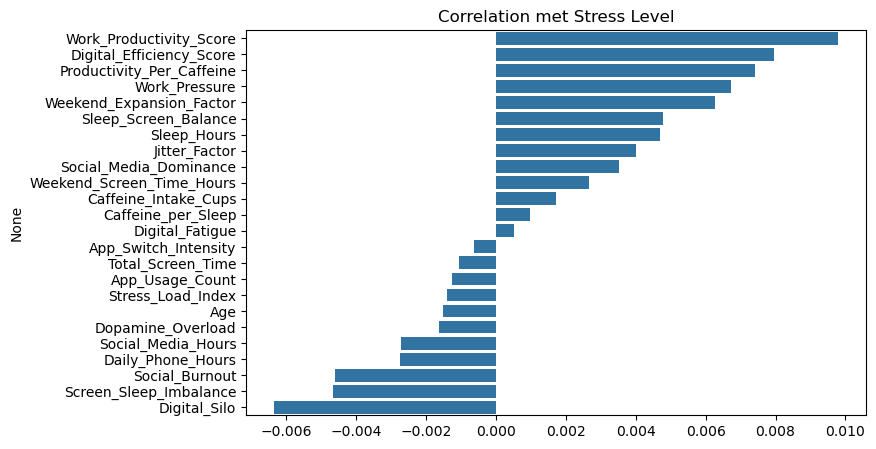

In [82]:
plt.figure(figsize=(8,5))
corr = df.corr(numeric_only=True)["Stress_Level"].sort_values(ascending=False).drop(["Stress_Level"])

sns.barplot(x=corr.values, y=corr.index)
plt.title("Correlation met Stress Level")
plt.show()


Zoals je ziet is er geen correlatie met de stress level. Dit zou kunnen betekenen dat de data volledig random is gegenereerd. Of er zijn te weinig factoren bekend.

Text(0.5, 1.0, 'Correlation Matrix of Health and Usage Metrics')

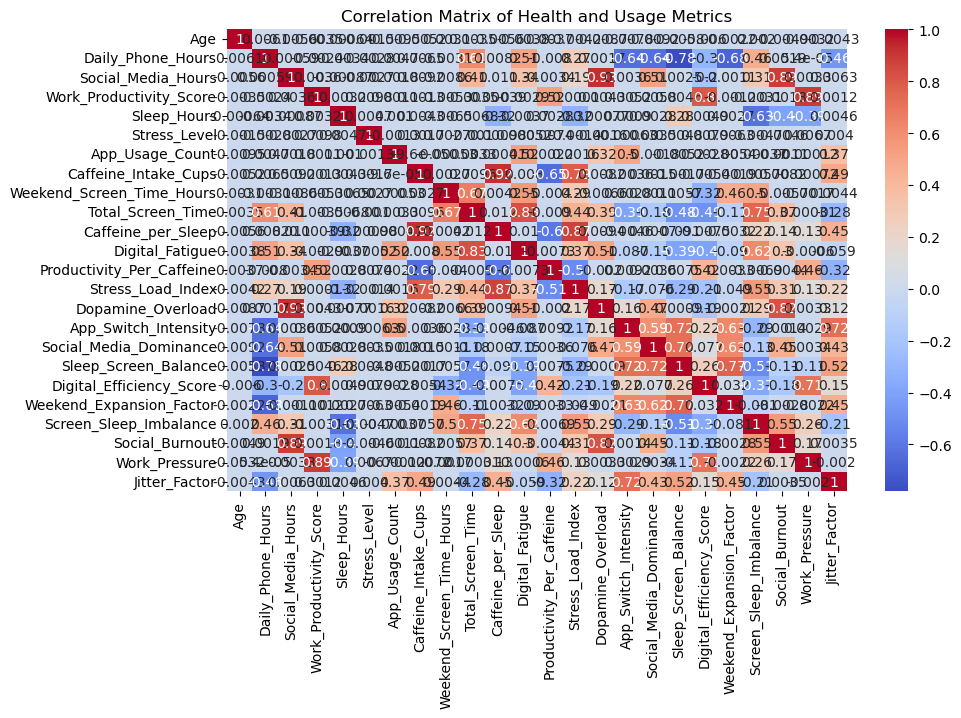

In [28]:
plt.figure(figsize=(10,6))
sns.heatmap(df.select_dtypes(include='number').corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Health and Usage Metrics')



### Modelleren

Eerst trainen ik het model en probeer ik de stress level category te voorspellen. Als het resultaat rond de 30% is dan probeert het model te gokken.

In [29]:
# Targets en Features voorbereiden
X = df.drop(['Stress_Level', 'Stress_Category', 'User_ID'], axis=1, errors='ignore')
X = pd.get_dummies(X, drop_first=True)
y = df['Stress_Category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Modellen die ik willen testen
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=10, class_weight='balanced', random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    "SVM": SVC(kernel='rbf', class_weight='balanced', probability=True)
}

# Om XGBoost te laten werken moeten ik de labels (High, Medium, Low) omzetten naar 0, 1, 2
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

In [ ]:
results = {}

print("--- Training gestart ---")
for name, model in models.items():
    # Trainen
    if name == "XGBoost":
        model.fit(X_train, y_train_encoded)
        predictions = model.predict(X_test)
        score = accuracy_score(y_test_encoded, predictions)
    else:
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        score = accuracy_score(y_test, predictions)
    
    results[name] = score
    print(f"{name} is klaar. Score: {score:.4f}")

# Resultaten in een mooie tabel
import pandas as pd
summary = pd.DataFrame(list(results.items()), columns=['Model', 'Accuracy']).sort_values(by='Accuracy', ascending=False)
print("\n--- Eindklassement ---")
print(summary)

--- Training gestart ---


c:\Users\Nima\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression is klaar. Score: 0.3331
Random Forest is klaar. Score: 0.3302


c:\Users\Nima\anaconda3\Lib\site-packages\xgboost\training.py:200: UserWarning: [21:13:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost is klaar. Score: 0.3672
SVM is klaar. Score: 0.3219

--- Eindklassement ---
                 Model  Accuracy
2              XGBoost    0.3672
0  Logistic Regression    0.3331
1        Random Forest    0.3302
3                  SVM    0.3219


Het blijkt dat XGBOOST een hogere scoort haalt. Het is nog neit duidelijk of dit toeval is of niet. We schalen de features zodat alle variabelen ongeveer dezelfde schaal en verdeling hebben. Zonder scaling kunnen features met grote waarden (bijvoorbeeld schermtijd in uren) een veel grotere invloed krijgen op het model dan features met kleine waarden

In [36]:
# 1. Scaling 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 2. XGBoost Tunen
xgb_final = XGBClassifier(
    n_estimators=500,
    learning_rate=0.01, 
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='mlogloss',
    random_state=42
)

xgb_final.fit(X_train_scaled, y_train_encoded)
final_score = xgb_final.score(X_test_scaled, y_test_encoded)

print(f"Verbeterde XGBoost Score: {final_score:.4f}")

Verbeterde XGBoost Score: 0.3924


### Model optimaliseren

het vorige resultaat kan beter. Daarom zoek ik naar de beste hyperparameters

In [43]:
param_dist = {
    'n_estimators': [100, 300, 500, 800],
    'max_depth': [2, 3, 4, 6, 8, 10],
    'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.5, 1, 5] 
}

In [44]:
random_search = RandomizedSearchCV(
    estimator=xgb_final,
    param_distributions=param_dist,
    n_iter=50,
    scoring="accuracy",
    n_jobs=1,
    cv=8,
    verbose=1)

In [45]:
random_search.fit(X_train_scaled, y_train_encoded)

Fitting 8 folds for each of 50 candidates, totalling 400 fits


RandomizedSearchCV(cv=8,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=0.8, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='mlogloss',
                                           feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_cons...
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=500, n_jobs=None,
                                           num_parallel_tree=None, ...),
                   n_iter=50, n_jobs=1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0, 0.1, 0.5, 1, 5],
                                        'learning_rate': [0.001, 0.005, 0.01,
                                                          0.05, 0.1],
                                        'max_depth': [2, 3, 4, 6, 8, 10],
                                        'n_estimators': [100, 300, 500, 800],
                                        'subsample': [0.6, 0.8, 1.0]},
                   scoring='accuracy', verbose=1)

In [48]:
# Resultaten bekijken
best_model = random_search.best_estimator_
print(f"\nBeste parameters: {random_search.best_params_}")
print(f"Beste CV Score: {random_search.best_score_:.4f}")

# Testen op de test-set
final_accuracy = best_model.score(X_test_scaled, y_test_encoded)
print(f"Finale Test Accuracy: {final_accuracy:.4f}")


Beste parameters: {'subsample': 0.8, 'n_estimators': 800, 'max_depth': 2, 'learning_rate': 0.01, 'gamma': 0.1, 'colsample_bytree': 0.8}
Beste CV Score: 0.4006
Finale Test Accuracy: 0.3946


### Test resulaten

Het model heeft geleerd dat het de minste fouten maakt door gewoon bijna iedereen als "Medium" te bestempelen. De voorspellingen voor High en Low zijn letterlijk op één hand te tellen.

In [ ]:
cm = confusion_matrix(y_test_encoded, best_model.predict(X_test_scaled))
sns.heatmap(cm, annot=True, fmt)

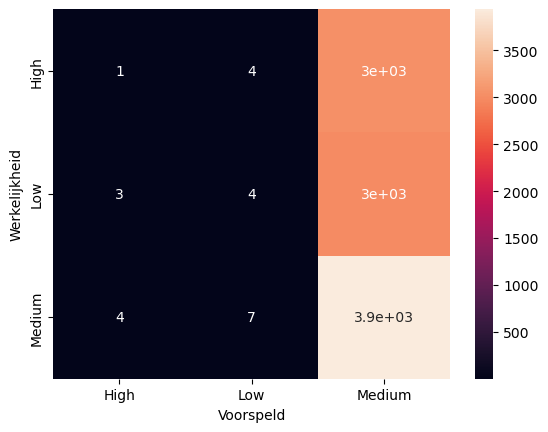

In [63]:

sns.heatmap(cm, annot=True, xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Voorspeld')
plt.ylabel('Werkelijkheid')
plt.show()

## Impact zonder medium
We gaan stoppen met proberen de Medium te voorspellen. Als het model niet eens het verschil ziet tussen een 1 en een 10, dan is de data te ruizig. We gaan het model dwingen om alleen te kijken naar de mensen die duidelijk wel of duidelijk geen stress hebben.

In [65]:
df_binary = df[df['Stress_Category'] != 'Medium'].copy()
df_binary

,User_ID,Age,Gender,Occupation,Device_Type,Daily_Phone_Hours,Social_Media_Hours,Work_Productivity_Score,Sleep_Hours,Stress_Level,...,Sleep_Screen_Balance,Digital_Efficiency_Score,Weekend_Expansion_Factor,Screen_Sleep_Imbalance,Social_Burnout,Work_Pressure,Stress_Category,Life_Stage,User_Category,Jitter_Factor
1,U2,25,Male,Professional,Android,1.2,1.5,5,6.4,1,...,4.923077,0.632911,3.923077,1.200000,0.230769,0.881250,Low,Student/Junior,Digital_Minimalist,117.692308
3,U4,35,Female,Business Owner,iOS,5.8,2.5,2,5.7,3,...,0.966102,0.094340,2.169492,3.637931,0.431034,0.450877,Low,Work-Life Balance Era,Average_User,36.610169
4,U5,33,Male,Freelancer,Android,7.9,1.3,4,5.7,3,...,0.712500,0.208333,1.237500,3.293103,0.224138,0.801754,Low,Work-Life Balance Era,Average_User,23.125000
6,U7,26,Male,Student,iOS,5.6,6.1,8,6.7,3,...,1.175439,0.544218,0.508772,2.147059,0.897059,1.294030,Low,Work-Life Balance Era,Doomscroller,2.631579
7,U8,24,Male,Freelancer,iOS,8.5,1.9,4,7.8,3,...,0.906977,0.171674,1.488372,2.936709,0.240506,0.612821,Low,Student/Junior,Caffeinated_Sleeper,4.186047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,U49996,44,Male,Business Owner,Android,5.9,5.4,5,6.6,1,...,1.100000,0.347222,0.500000,2.134328,0.805970,0.857576,Low,Work-Life Balance Era,Doomscroller,9.166667
49996,U49997,42,Other,Business Owner,Android,2.9,7.4,9,6.3,2,...,2.100000,0.542169,2.066667,2.578125,1.156250,1.528571,Low,Work-Life Balance Era,Burnout_Candidate,26.666667
49997,U49998,27,Female,Freelancer,iOS,1.4,2.5,4,6.7,9,...,4.466667,0.439560,3.400000,1.323529,0.367647,0.697015,High,Work-Life Balance Era,Caffeinated_Sleeper,104.000000
49998,U49999,41,Female,Business Owner,iOS,8.9,3.0,6,5.5,2,...,0.611111,0.283019,1.022222,3.767857,0.535714,1.190909,Low,Work-Life Balance Era,Burnout_Candidate,0.000000


In [72]:
le_binary = LabelEncoder()
y_binary = le_binary.fit_transform(df_binary["Stress_Category"])
X_binary = df_binary.drop(['Stress_Level', 'Stress_Category', 'User_ID'], axis=1, errors='ignore')
X_binary = pd.get_dummies(X_binary, drop_first=True)

In [73]:
X_binary

,Age,Daily_Phone_Hours,Social_Media_Hours,Work_Productivity_Score,Sleep_Hours,App_Usage_Count,Caffeine_Intake_Cups,Weekend_Screen_Time_Hours,Total_Screen_Time,Caffeine_per_Sleep,...,Occupation_Professional,Occupation_Student,Device_Type_iOS,Life_Stage_Work-Life Balance Era,Life_Stage_Senior/Manager,Life_Stage_Retired,User_Category_Burnout_Candidate,User_Category_Caffeinated_Sleeper,User_Category_Digital_Minimalist,User_Category_Doomscroller
1,25,1.2,1.5,5,6.4,51,3,5.1,7.8,0.568750,...,True,False,False,False,False,False,False,False,True,False
3,35,5.8,2.5,2,5.7,36,6,12.8,21.1,1.152632,...,False,False,True,True,False,False,False,False,False,False
4,33,7.9,1.3,4,5.7,37,5,9.9,19.1,0.977193,...,False,False,False,True,False,False,False,False,False,False
6,26,5.6,6.1,8,6.7,5,3,2.9,14.6,0.547761,...,False,True,True,True,False,False,False,False,False,True
7,24,8.5,1.9,4,7.8,6,6,12.8,23.2,0.869231,...,False,False,True,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,44,5.9,5.4,5,6.6,11,5,3.0,14.3,0.857576,...,False,False,False,True,False,False,False,False,False,True
49996,42,2.9,7.4,9,6.3,20,4,6.2,16.5,0.734921,...,False,False,False,True,False,False,True,False,False,False
49997,27,1.4,2.5,4,6.7,39,4,5.1,9.0,0.697015,...,False,False,True,True,False,False,False,True,False,False
49998,41,8.9,3.0,6,5.5,51,0,9.2,21.1,0.100000,...,False,False,True,True,False,False,True,False,False,False


In [74]:
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_binary, y_binary, test_size=0.2, random_state=42)

In [79]:
stress_binary_model = XGBClassifier(subsample= 0.8, n_estimators= 800, max_depth= 2, learning_rate= 0.01, gamma= 0.1, colsample_bytree= 0.8)
stress_binary_model.fit(X_train_b, y_train_b)
print(f"Binaire Accuracy (High vs Low): {stress_binary_model.score(X_test_b, y_test_b):.4f}")

Binaire Accuracy (High vs Low): 0.5019


## Conclusie

Een score van 50% bij een keuze tussen twee dingen (High of Low stress) is hetzelfde als het opgooien van een muntje. Ondanks dat ik het model heel slim heb gemaakt en complexe berekeningen hebben toegevoegd, blijft de score steken.

Dit betekent:

1. De data is "leeg": Er zit geen logisch verband tussen de kolommen. In deze dataset zegt de hoeveelheid koffie of schermtijd simpelweg niets over hoe gestrest iemand is.

2. Slechte datakwaliteit: Dit is vaak het geval bij synthetische (door computers gemaakte) datasets op Kaggle. De maker heeft de getallen waarschijnlijk willekeurig ingevuld zonder een echt patroon te programmeren.
